Name: Shiska Raut <br>
ID: 1001526329

In [383]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

## Read training/evaluation data

**Argument(s):** 
1) filename: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y) <br>
2) dtype_x : datatype of features <br>
3) dtype_y: datatype of label <br>

**Return(s):** 'X, Y' where X is a numpy array of feature vectors and Y is the target label vector.
Note: Each column in the array(s) epresents a single datapoint.

In [384]:
def get_X_Y_arrays(filename, dtype_x, dtype_y):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()
        
    # initialize list to store feature and labels for training data
    features = []             
    labels = []
    
    with f:
        line = f.readline()
        while line != '':
            # strip newline and outer parenthesis
            line = line.strip('\n')
            line = line.strip('( )')
            
            # extrace label and append to labels list
            single_label = line.split('), ')[-1]
            labels.append(single_label)
            
            # extrace features and append to features list
            feat = line.split('), ')[0].split(', ')
            features.append(feat)
            
            # read next line
            line = f.readline()
        
        # create dataframe of features and append labels
        X = np.array(features, dtype = dtype_x, ndmin = 2)
        
        # convert labels list to array
        Y = np.array(labels, dtype = dtype_y, ndmin = 2)
        
        return X.transpose(), Y

### Softmax Regression

#### Helper Functions

#### one_hot_encoder(arr) : return encoded_arr, label_idx_dict
**arr:** <br>
[['Ceramic' 'Metal' 'Metal' 'Metal' 'Ceramic' 'Plastic' 'Plastic'
  'Plastic' 'Plastic' 'Plastic' 'Plastic' 'Ceramic']]<br>  
**encoded_arr:** <br>
[[0 1 1 1 0 0 0 0 0 0 0 0]<br>
 [0 0 0 0 0 1 1 1 1 1 1 0]<br>
 [1 0 0 0 1 0 0 0 0 0 0 1]] <br>
**encoding_dict:** <br>
{'Metal': 0, 'Plastic': 1, 'Ceramic': 2}<br>
**decoding_dict:** <br>
{0:'Metal', 1:'Plastic', 2:'Ceramic'}

In [385]:
# given an array of attribute values for a categocial attribute,
# preforms one-hot-encoding and returns resulting binary array
def one_hot_encoder(arr):
    __, n_samples = arr.shape

    # get unique labels
    uniq_labels = set(arr[0, :].tolist())

    # get number of total attribute values
    n_labels = len(uniq_labels)

    # create an array of size n_labels*n_samples to store encoded values
    encoded_arr = np.zeros((n_labels, n_samples), dtype=int)

    # create dictionary to store row indev of each attribute value
    encoding_dict = {}
    for i, v in enumerate(uniq_labels):
        encoding_dict[v] = i

    # fill encoded_arr using attribute index dictionary and input arr
    for i in range(n_samples):
        # get index to encode as 1
        idx = encoding_dict[arr[0, i]]
        encoded_arr[idx, i] = 1

    # get inverse of the dictionary
    decoding_dict = {v: k for k, v in encoding_dict.items()}

    return encoded_arr, encoding_dict, decoding_dict


# given a one-hot encoded array and a decoding_dict returns decoded array
def get_decoded_arr(arr, decoding_dict):

    # get number of samples
    n_samples = arr.shape[1]

    arr_decoded = np.zeros((1, n_samples), dtype = object)

    for i in range(n_samples):
        arr_decoded[:, i] = decoding_dict[np.argmax(arr[:, i])]

    return arr_decoded


# given an array of labels and encoding dict returns encoded array
def get_encoded_arr(arr, encoding_dict):

    # get number of classes and number of samples
    n_class = len(encoding_dict.keys())
    n_samples = arr.shape[1]

    encoded_arr = np.zeros((n_class, n_samples), dtype = int)

    for i in range(n_samples):

        idx = encoding_dict[arr[:, i][0]]
        encoded_arr[idx, i] = int(1)

    return encoded_arr

# adds bias as the first row to a dataset
def add_bias(X):
    
    n_feat, n_samples = X.shape
    X_b = np.ones((n_feat+1, n_samples), dtype = float)
    X_b[1::,:] = X
    
    return X_b


# plots a line graph 
def plot_change(X, title, xlab, ylab):
    
    fig = plt.figure(figsize = (10, 6))
    plt.plot(X, color = 'red')
    
    # add title and labels
    plt.title(title, fontdict = {'fontsize': 15})
    plt.xlabel(xlab, fontdict = {'fontsize': 12})
    plt.ylabel(ylab, fontdict = {'fontsize': 12})
    plt.grid()

    
# compares two arrays and returns class accuracy
# Y_pred.shape == Y.shape = ndim, n_samples 
# Y_pred.dtype = Y.dtype + string object
def get_class_acc(Y_pred, Y):
    
    # create a dict to store class accuracy
    class_acc = {}
    
    # get all unique classes
    classes = set(Y[0,:].tolist())
    
    # get number of samples
    n_samples = Y_pred.shape[1]
    
    # calculate total occurence and accurate predictions for each class
    for c in classes:
        
        total = 0
        acc_vals = 0
        
        for i in range(n_samples):
            if Y[:,i] == c:
                total = total + 1
                if Y[:,i] == Y_pred[:,i]:
                    acc_vals = acc_vals + 1
                
        class_acc[c] = acc_vals/total
        
    return class_acc


# compares two arrays and returns overall accuracy
# Y_pred.shape == Y.shape = ndim, n_samples 
# Y_pred.dtype = Y.dtype + string object
def get_acc(Y_pred, Y):
    
    n_samples = Y_pred.shape[1]
    
    # reutrn overall accuracy
    return (np.sum(Y == Y_pred))/n_samples


### Functions for Training and Prediction

In [386]:
# given a vector of parobaility values, returns label with max probability for a single sample
def get_sample_prediction_label(sfmax_net, decoding_dict):
    
    # return label with max probability value
    return decoding_dict[int(np.argmax(sfmax_net, axis = 0))]


# uses softmax function and parameter matrix to get probability values
# for multiclass classification
def get_sample_prediction_values(x_sample, model_params):
    
    # calculate linear net value
    net = np.dot(model_params, x_sample)
    
    # calculate exponential value for rach class
    exp_net = np.exp(net, dtype = float)
    
    # calculate softmax value for each class
    sfmax_net = exp_net/np.sum(exp_net, axis = 0, dtype = float)
    
    return sfmax_net


# gets predictions for an entire test dataset
def get_predictions(X_test, model_params, label_idx_dict):

    # initialize list to store predictions
    Y_pred = []

    # get number of test samples
    n_feat, n_samples = X_test.shape

    for i in range(n_samples):
    
        x_sample = X_test[:,i].reshape(n_feat, 1)
        y_pred_values = get_sample_prediction_values(X_test[:,i], model_params)
        y_pred_label = get_sample_prediction_label(y_pred_values, label_idx_dict)
        Y_pred.append(y_pred_label)

    # convert labels list to numpy array
    Y_pred = np.array(Y_pred, dtype = str, ndmin = 2)

    return Y_pred  


# training with batch gradient descent
def train_softmax_regressor_batch(X_train, Y_train, alpha, epochs):
    
    # get number of features and samples
    n_feat, n_samples = X_train.shape
    
    # get no of classes/labels
    n_class, __ = Y_train.shape

    # get paramater matrix
    model_params = np.random.uniform(-0.01, 0.01, size = (n_class, n_feat))

    # initialize list to store net change in parameter values
    epoch_change_model_params = []
    
    for i in range(epochs):

        # initialize gradient vector for each epoch
        gradient_mtx = np.zeros((n_class, n_feat), dtype = float)

        for j in range(n_samples):
            
            # pick a sample 
            x_sample = X_train[:,j].reshape(n_feat,1)
            y_sample = Y_train[:,j].reshape(n_class, 1)
            
            # get prediction value
            y_pred = get_sample_prediction_values(x_sample, model_params)

            # calculate gradient matrix
            sample_gradient = np.dot((y_sample - y_pred), x_sample.transpose())
            gradient_mtx = gradient_mtx + sample_gradient
            
        # adjust parameter values using batch gradient descent 
        updated_params = model_params + (alpha*gradient_mtx)
        
        # get the net change in parameters
        net_change = np.sum(np.abs(model_params - updated_params))
        epoch_change_model_params.append(net_change)
            
        # set updated parameters as new parameters  
        model_params = updated_params.copy()
        
    # return final parameter matrix
    return model_params, epoch_change_model_params


### Provide Filename:
1) Training/evaluation file: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y)

In [387]:
fname = 'data.txt'

X, Y = get_X_Y_arrays(fname, float, str)

### Plot class distribution of training data provided in assignment

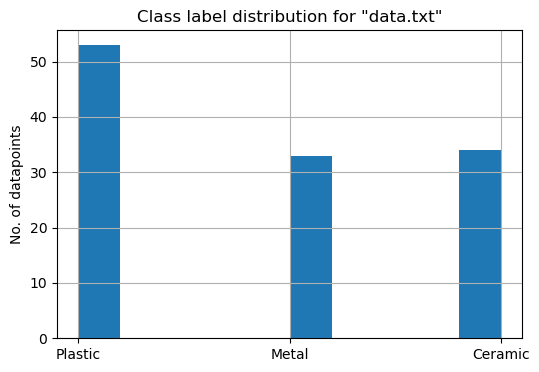

In [388]:
plt.figure(figsize = (6, 4))
plt.title(f'Class label distribution for "{fname}"')
plt.ylabel('No. of datapoints')
plt.hist(Y.squeeze())
plt.grid()

In [389]:
# add bias to X training data
X_b = add_bias(X)

# get encoded values for Y_train
Y_encoded, encoding_dict, decoding_dict = one_hot_encoder(Y)

### Split data into training and test set

In [390]:
def split_data(X, Y, n_test_samples):

    X_test = X[:, 0:n_test_samples]
    Y_test = Y[:, 0:n_test_samples]

    X_train = np.delete(X, np.s_[0:n_test_samples], axis = 1)
    Y_train = np.delete(Y, np.s_[0:n_test_samples], axis = 1)

    return X_train, Y_train, X_test, Y_test

In [391]:
# split data into training and test set
X_train, Y_train, X_test, Y_test = split_data(X_b, Y_encoded, 15)

### 1) a
### Bagging Rautine

In [408]:
# creates a list of 'n' dataset arrays created via random sampling with replacement 
def get_bootstrapped_datasets(X, Y, n):
    
    # initialze list to store datasets
    X_list = []
    Y_list = []
    
    # get number of samples
    n_samples = X.shape[1]
    
    for i in range(n):
        
        # create array of same size as the original dataset
        X_new = np.zeros((X.shape))
        Y_new = np.zeros((Y.shape))
        
        for j in range(n_samples):
            
            # randomply pick an index
            idx = np.random.randint(0, n_samples)
            
            X_new[:, j] = X[:, idx]
            Y_new[:, j] = Y[:, idx]
            
        X_list.append(X_new)
        Y_list.append(Y_new)
    
    return X_list, Y_list


# trains n_classifiers on bootstrapped training data and returns model paramaters
# and training accuracy values
def train_classifiers(X_train, Y_train, n_classifiers, epochs, alpha, decoding_dict):
    
    # create datasets
    datasets_X, datasets_Y = get_bootstrapped_datasets(X_train, Y_train, n_classifiers)
    
    # create list to store model_parameters and training accuracy
    model_params_list = []
    training_acc_list = []
    
    for i in range(n_classifiers):
        
        # train model and get predictions
        model_params, __ = train_softmax_regressor_batch(datasets_X[i], datasets_Y[i], alpha, epochs)
        
        # get prediction on training data
        Y_train_pred = get_predictions(datasets_X[i], model_params, decoding_dict)
        
        # decode labels
        Y_train_labels = get_decoded_arr(datasets_Y[i], decoding_dict)
        
        # append model parameters
        model_params_lista.append(model_params)
        training_acc_list.append(get_acc(Y_train_pred, Y_train_labels))
        
    # return parameters for all models and training accuracy values
    return model_params_list, training_acc_list


# returns final prediction based on n_classifiers
# and overall test accuracy
def get_ensemble_prediction(X_test, model_params_list, n_classifiers):
    
    

### 1 b)
###  Single Classifier

Train single softmax regression classifier on the original train and test data.

In [393]:
# set epochs and alpha
epochs = 1000
alpha = 0.001

# train model and get predictions
model_params, epoch_change_model_params = train_softmax_regressor_batch(X_train, Y_train, alpha, epochs)

Y_train_pred = get_predictions(X_train, model_params, decoding_dict)
Y_test_pred = get_predictions(X_test, model_params, decoding_dict)

#### Get accuracy values for single classifier

In [405]:
# get decoded arrays for Y_train and Y_test
Y_train_labels = get_decoded_arr(Y_train, decoding_dict)
Y_test_labels = get_decoded_arr(Y_test, decoding_dict)

# get accuracy for training and test data
train_acc = get_acc(Y_train_pred, Y_train_labels)
test_acc = get_acc(Y_test_pred, Y_test_labels)
print(f'Overall Training accuracy is {train_acc:.3f}.')
print(f'Overall Test accuracy is {test_acc:.3f}.')

Overall Training accuracy is 0.438.
Overall Test accuracy is 0.667.


In [406]:
train_class_acc = get_class_acc(Y_train_pred, Y_train_labels)
test_class_acc = get_class_acc(Y_test_pred, Y_test_labels)

print(f'Training class accuracy is:')
for k, v in train_class_acc.items():
    print(f'{k}: {v:0.3f}')
    
print(f'\nTest class accuracy is:')
for k, v in test_class_acc.items():
    print(f'{k}: {v:0.3f}')

Training class accuracy is:
Ceramic: 0.000
Metal: 0.115
Plastic: 0.935

Test class accuracy is:
Ceramic: 0.000
Metal: 0.429
Plastic: 1.000


### Bagging with 10, 50, 100 classifiers

#### 10 Classifiers

In [409]:
datasets_X, datasets_Y = get_bootstrapped_datasets(X_train, Y_train, 10)

In [ ]:
# create list to store all predictions on test data
# for each classifier
test_predictions = []

